# Finetuning bert-tiny-finetuned-sms-spam-detection 

Using mrm8488/bert-tiny-finetuned-sms-spam-detection sequence classification model + fine tuning using 20% of data to classify model.

In [368]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

In [384]:
pd.set_option('display.width', 100)

In [294]:
spam_df = pd.read_excel('../../src/data/spam.xlsx')
spam_df['is_not_trivial_proxy'] = (spam_df['is_trivial'] == False)


checkmate_df = pd.read_csv('../../src/data/CM_MSG_T_130523.csv')
checkmate_df['is_trivial'] = (checkmate_df['taggedCategory']=='Trivial')
checkmate_df['is_not_trivial_proxy'] = (checkmate_df['is_trivial'] == False)
# Not all sentences are imported as strings
checkmate_df['text'] = checkmate_df['text'].astype('str')

# Remove empty rows
spam_df = spam_df[['v2','is_trivial','is_not_trivial_proxy']]
# Rename columns
spam_df.columns = ['text', 'is_trivial', 'is_not_trivial_proxy']
# Not all sentences are imported as strings
spam_df['text'] = spam_df['text'].astype('str')

In [295]:
spam_dataset = Dataset.from_pandas(spam_df, split='train')
checkmate_dataset = Dataset.from_pandas(checkmate_df, split='train')

In [296]:
print(spam_dataset)
print(checkmate_dataset)

Dataset({
    features: ['text', 'is_trivial', 'is_not_trivial_proxy'],
    num_rows: 5571
})
Dataset({
    features: ['text', 'taggedCategory', 'type', 'isMachineCategorised', 'truthScore', 'is_trivial', 'is_not_trivial_proxy'],
    num_rows: 168
})


### Splitting data into training and testing

In [370]:
spam_dataset = spam_dataset.class_encode_column("is_not_trivial_proxy")
spam_dataset = spam_dataset.train_test_split(test_size=0.80, stratify_by_column='is_not_trivial_proxy')

checkmate_dataset = checkmate_dataset.class_encode_column("is_not_trivial_proxy")
checkmate_dataset = checkmate_dataset.train_test_split(test_size=0.50, stratify_by_column='is_not_trivial_proxy')

In [298]:
print(spam_dataset)
print(checkmate_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'is_trivial', 'is_not_trivial_proxy'],
        num_rows: 1114
    })
    test: Dataset({
        features: ['text', 'is_trivial', 'is_not_trivial_proxy'],
        num_rows: 4457
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'taggedCategory', 'type', 'isMachineCategorised', 'truthScore', 'is_trivial', 'is_not_trivial_proxy'],
        num_rows: 84
    })
    test: Dataset({
        features: ['text', 'taggedCategory', 'type', 'isMachineCategorised', 'truthScore', 'is_trivial', 'is_not_trivial_proxy'],
        num_rows: 84
    })
})


### Finetune Dataset with 20% of spam data

In [299]:
tokenizer = AutoTokenizer.from_pretrained('mrm8488/bert-tiny-finetuned-sms-spam-detection', model_max_length=512)

In [300]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

In [301]:
print(spam_dataset['test']['text'])

['Here is your discount code RP176781. To stop further messages reply stop. www.regalportfolio.co.uk. Customer Services 08717205546', 'Havent mus ask if u can 1st wat. Of meet 4 lunch den u n him meet can already lor. Or u wan 2 go ask da ge 1st then confirm w me asap?', "Haven't eaten all day. I'm sitting here staring at this juicy pizza and I can't eat it. These meds are ruining my life.", "Babe? You said 2 hours and it's been almost 4 ... Is your internet down ?", 'Send me your id and password', 'Leave it. U will always be ignorant.', 'haha but no money leh... Later got to go for tuition... Haha and looking for empty slots for driving lessons', 'Ok . . now i am in bus. . If i come soon i will come otherwise tomorrow', '\\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAROUND! HOWDY GORGEOUS', 'This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate ', 'Huh so late... Fr dinner?', "Well I'm g

In [302]:
tokenized_spam_dataset = tokenizer(spam_dataset['train']['text'], return_tensors='np', padding=True, truncation=True)

In [303]:
tokenized_spam_dataset = dict(tokenized_spam_dataset)

In [304]:
spam_labels = np.array(spam_dataset['train']['is_not_trivial_proxy'])

In [305]:
model = TFAutoModelForSequenceClassification.from_pretrained('mrm8488/bert-tiny-finetuned-sms-spam-detection', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [306]:
model.compile(optimizer=Adam(3e-5))

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [307]:
model.fit(tokenized_spam_dataset, spam_labels)

35/35 [==============================] - 14s 331ms/step - loss: 0.1011


In [308]:
tokenized_spam_test = tokenizer(spam_dataset['test']['text'], return_tensors='np', padding=True, truncation=True)

outputs_spam_test = model(tokenized_spam_test).logits

prediction_spam_test = np.argmax(outputs_spam_test, axis=1)

In [309]:
print(type(tokenized_spam_test))
print((tokenized_spam_test).keys())
print(len(tokenized_spam_test['input_ids'][2]))
print(len(tokenized_spam_test['token_type_ids'][0]))
print(len(tokenized_spam_test['attention_mask'][0]))

print((tokenized_spam_test['input_ids'][2]))


<class 'transformers.tokenization_utils_base.BatchEncoding'>
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
238
238
238
[  101  4033  1005  1056  8828  2035  2154  1012  1045  1005  1049  3564
  2182  4582  2012  2023 28900 10733  1998  1045  2064  1005  1056  4521
  2009  1012  2122 19960  2015  2024 27853  2026  2166  1012   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0   

In [310]:
target_spam_test = np.array(spam_dataset['test']['is_not_trivial_proxy'])

In [311]:
print(target_spam_test)

[1 0 0 ... 1 0 0]


In [312]:
spam_predicted_vs_output = pd.DataFrame([spam_dataset['test']['text'],target_spam_test,prediction_spam_test]).T
spam_predicted_vs_output.rename(columns={0:'text', 1:'target',2:'prediction'}, inplace=True)

print(spam_predicted_vs_output)

                                                   text target prediction
0     Here is your discount code RP176781. To stop f...      1          1
1     Havent mus ask if u can 1st wat. Of meet 4 lun...      0          0
2     Haven't eaten all day. I'm sitting here starin...      0          0
3     Babe? You said 2 hours and it's been almost 4 ...      0          0
4                          Send me your id and password      0          0
...                                                 ...    ...        ...
4452   gonna let me know cos comes bak from holiday ...      0          0
4453  PRIVATE! Your 2003 Account Statement for <fone...      1          1
4454  LookAtMe!: Thanks for your purchase of a video...      1          1
4455  swhrt how u dey,hope ur ok, tot about u 2day.l...      0          0
4456  Please da call me any mistake from my side sor...      0          0

[4457 rows x 3 columns]


In [313]:
# Calculate the recall of this methodology
true_non_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==True)])
true_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==False)])

false_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==False)])
false_non_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==True)])


In [314]:
recall = len(true_non_trivial)/(len(true_non_trivial)+len(false_trivial))
precision = len(true_non_trivial)/(len(true_non_trivial)+len(false_non_trivial))
negativepredictivevalue = len(true_trivial)/(len(true_trivial)+len(false_trivial))
accuracy = (len(true_trivial)+len(true_non_trivial))/(len(true_trivial)+len(true_non_trivial)+len(false_trivial)+len(false_non_trivial))

print(f'Recall is: {recall*100}%')
print(f'Precision is: {precision*100}%')
print(f'Negative Predictive Value is: {negativepredictivevalue*100}%')
print(f'Accuracy is: {accuracy*100}%')

Recall is: 89.43894389438944%
Precision is: 98.18840579710145%
Negative Predictive Value is: 98.36107554417414%
Accuracy is: 98.3396903746915%


In [315]:
print(f'true_trivial is: {len(true_trivial)}')
print(f'true_non_trivial is: {len(true_non_trivial)}')
print(f'false_non_trivial is: {len(false_non_trivial)}')
print(f'false_trivial is: {len(false_trivial)}')

true_trivial is: 3841
true_non_trivial is: 542
false_non_trivial is: 10
false_trivial is: 64


In [371]:
tokenized_checkmate_test = tokenizer(checkmate_dataset['test']['text'], return_tensors='np', padding=True, truncation=True, max_length=248)

outputs_checkmate_test = model(tokenized_checkmate_test).logits

# Choose the larger of the logits between the two values
prediction_checkmate_test = np.argmax(outputs_checkmate_test, axis=1)

In [372]:
target_checkmate_test = np.array(checkmate_dataset['test']['is_not_trivial_proxy'])

In [373]:
checkmate_predicted_vs_output = pd.DataFrame([checkmate_dataset['test']['text'],target_checkmate_test,prediction_checkmate_test]).T
checkmate_predicted_vs_output.rename(columns={0:'text', 1:'target',2:'prediction'}, inplace=True)

print(checkmate_predicted_vs_output)

                                                 text target prediction
0                                               scam?      0          0
1   🙋‍♀ If you know anyone born between 1950-1959,...      1          0
2   Fast Cash Service                \n3k 268 x12m...      1          1
3                                               Hello      0          0
4                                                 nan      1          0
..                                                ...    ...        ...
79  🌧️ 🌧️ 🌧️ 🌧️ 🌧️ 🌧️ 🌧️ \n\n*From today until 30/...      1          0
80                                                nan      1          0
81                                                nan      1          0
82  Date: 24 March 2023 at 2:24:03 pm AEDT\nTo: \n...      1          0
83  Fast Cash Service                \n3k 268 x12m...      1          1

[84 rows x 3 columns]


In [374]:
# Calculate the recall of this methodology
true_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==True)])
true_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==False)])

false_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==False)])
false_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==True)])


In [375]:

# Non-trivial / Spam = 1
# Trivial / Ham = 0

recall = len(true_non_trivial)/(len(true_non_trivial)+len(false_trivial))
precision = len(true_non_trivial)/(len(true_non_trivial)+len(false_non_trivial))
negativepredictivevalue = len(true_trivial)/(len(true_trivial)+len(false_trivial))
accuracy = (len(true_trivial)+len(true_non_trivial))/(len(true_trivial)+len(true_non_trivial)+len(false_trivial)+len(false_non_trivial))

print(f'Recall is: {recall*100}%')
print(f'Precision is: {precision*100}%')
print(f'Negative Predictive Value is: {negativepredictivevalue*100}%')
print(f'Accuracy is: {accuracy*100}%')

Recall is: 56.25%
Precision is: 97.2972972972973%
Negative Predictive Value is: 40.42553191489361%
Accuracy is: 65.47619047619048%


In [376]:
print(f'true_trivial is: {len(true_trivial)}')
print(f'true_non_trivial is: {len(true_non_trivial)}')
print(f'false_non_trivial is: {len(false_non_trivial)}')
print(f'false_trivial is: {len(false_trivial)}')

true_trivial is: 19
true_non_trivial is: 36
false_non_trivial is: 1
false_trivial is: 28


In [377]:
print(false_trivial)

                                                 text target prediction
1   🙋‍♀ If you know anyone born between 1950-1959,...      1          0
4                                                 nan      1          0
5   This is one of the most profound description o...      1          0
9   HEAT WAVE DANGER\nWARNING to Singaporeans \n* ...      1          0
13                                      Is this scam?      1          0
16  We are away right now, let us know how we can ...      1          0
18  This is Zoey from \nShopee's marketing departm...      1          0
19  Just received a call fm this hp no. n she said...      1          0
22                                    Is this a scam?      1          0
27                                                nan      1          0
32  \n\nHi, this is Julie from Chase Travel Singap...      1          0
36  Hello, my name is Sarah, from CME Group. We've...      1          0
37  From tomorrow till August 22 the weather will ...      1    

Performed with 64.5% acccuracy for checkmate data which is much less than desired. It also was too lenient in predicting trivial messages.

Further action:
- Standardise the is_trivial labelling as the pretrained model is labelled as 0 -> ham, 1 -> spam, but is_trivial is labelled as 0 -> is_non_trivial, 1 -> is_trivial
    - But we want to keep spam results as they are considered potentially scams and hence should be is_non_trivial
    - Current work around is to create a is_not_trivial_proxy column
- Understand the fine-tuning procedure a bit more and test if we can improve the accuracy on spam dataset without sacrificing the accuracy on the checkmate dataset
- Figure out the maximum token length taken in by the model (if it is 248 as I had to manually set it based on observation)

#### Adjusting Prediction Threshold

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [ ]:
probability_checkmate_test = np.apply_along_axis(softmax, 1, outputs_checkmate_test)

In [ ]:
def classify_with_threshold(x, y):
    ''' If the probability of x% (being trivial) is larger than the threshold y%, then the text is trivial, else non-trivial'''
    return x >= y

In [ ]:
adjusted_prediction = np.apply_along_axis(classify_with_threshold, 0, probability_checkmate_test[:, 1], 0.05)

In [ ]:
adjusted_prediction = adjusted_prediction.astype(int)

In [318]:
adjusted_checkmate_predicted_vs_output = pd.DataFrame([checkmate_dataset['test']['text'],target_checkmate_test,adjusted_prediction, probability_checkmate_test[:,1]]).T
adjusted_checkmate_predicted_vs_output.rename(columns={0:'text', 1:'target',2:'prediction',3:'probability'}, inplace=True)

print(adjusted_checkmate_predicted_vs_output)

                                                 text target prediction  \
0                                               scam?      1          1   
1   🙋‍♀ If you know anyone born between 1950-1959,...      1          1   
2   Fast Cash Service                \n3k 268 x12m...      0          1   
3                                               Hello      1          1   
4                                                 nan      1          1   
..                                                ...    ...        ...   
79  🌧️ 🌧️ 🌧️ 🌧️ 🌧️ 🌧️ 🌧️ \n\n*From today until 30/...      1          1   
80                                                nan      1          1   
81                                                nan      1          1   
82  Date: 24 March 2023 at 2:24:03 pm AEDT\nTo: \n...      1          1   
83  Fast Cash Service                \n3k 268 x12m...      1          1   

   probability  
0     0.858595  
1     0.148046  
2     0.063645  
3     0.695932  
4     0.260104

In [319]:
# Calculate the recall of this methodology
true_non_trivial = (adjusted_checkmate_predicted_vs_output[(adjusted_checkmate_predicted_vs_output['target']==True) & (adjusted_checkmate_predicted_vs_output['prediction']==True)])
true_trivial = (adjusted_checkmate_predicted_vs_output[(adjusted_checkmate_predicted_vs_output['target']==False) & (adjusted_checkmate_predicted_vs_output['prediction']==False)])

false_trivial = (adjusted_checkmate_predicted_vs_output[(adjusted_checkmate_predicted_vs_output['target']==True) & (adjusted_checkmate_predicted_vs_output['prediction']==False)])
false_non_trivial = (adjusted_checkmate_predicted_vs_output[(adjusted_checkmate_predicted_vs_output['target']==False) & (adjusted_checkmate_predicted_vs_output['prediction']==True)])


In [378]:

# Non-trivial / Spam = 1
# Trivial / Ham = 0

recall = len(true_non_trivial)/(len(true_non_trivial)+len(false_trivial))
precision = len(true_non_trivial)/(len(true_non_trivial)+len(false_non_trivial))
negativepredictivevalue = len(true_trivial)/(len(true_trivial)+len(false_trivial))
accuracy = (len(true_trivial)+len(true_non_trivial))/(len(true_trivial)+len(true_non_trivial)+len(false_trivial)+len(false_non_trivial))

print(f'Recall is: {recall*100}%')
print(f'Precision is: {precision*100}%')
print(f'Negative Predictive Value is: {negativepredictivevalue*100}%')
print(f'Accuracy is: {accuracy*100}%')

Recall is: 56.25%
Precision is: 97.2972972972973%
Negative Predictive Value is: 40.42553191489361%
Accuracy is: 65.47619047619048%


In [379]:
print(f'true_trivial is: {len(true_trivial)}')
print(f'true_non_trivial is: {len(true_non_trivial)}')
print(f'false_non_trivial is: {len(false_non_trivial)}')
print(f'false_trivial is: {len(false_trivial)}')

true_trivial is: 19
true_non_trivial is: 36
false_non_trivial is: 1
false_trivial is: 28


Even with softmax and adjusting the prediction threshold to as low as 0.05, the negative predictive value is only 61.2% and a huge number of false trivials are present.

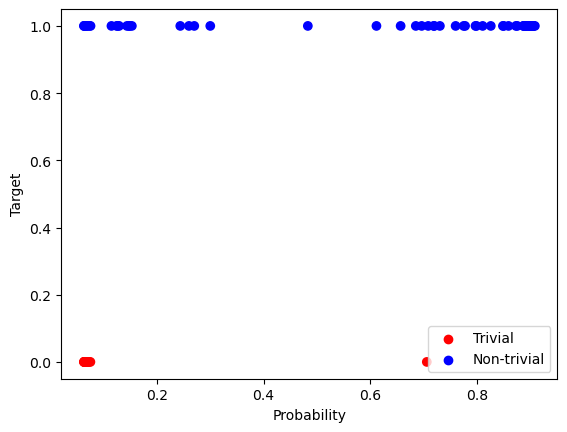

In [322]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract relevant columns for plotting
probabilities = adjusted_checkmate_predicted_vs_output['probability']
targets = adjusted_checkmate_predicted_vs_output['target']

# Define colors based on targets
colors = ['red' if target == 0 else 'blue' for target in targets]

# Plot the graph
plt.scatter(probabilities, targets, c=colors)
plt.xlabel('Probability')
plt.ylabel('Target')
plt.legend(handles=[plt.scatter([], [], c='red', label='Trivial'),
                    plt.scatter([], [], c='blue', label='Non-trivial')])

plt.show()


### With finetuning using 50% of checkmate data

In [323]:
model = TFAutoModelForSequenceClassification.from_pretrained('mrm8488/bert-tiny-finetuned-sms-spam-detection', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [324]:
model.compile(optimizer=Adam(3e-5))

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [325]:
tokenized_checkmate_dataset = tokenizer(checkmate_dataset['train']['text'], return_tensors='np', padding=True, truncation=True)


In [326]:
tokenized_checkmate_dataset = dict(tokenized_checkmate_dataset)

In [327]:
checkmate_labels = np.array(checkmate_dataset['train']['is_not_trivial_proxy'])

In [328]:
model.fit(tokenized_checkmate_dataset, checkmate_labels)

3/3 [==============================] - 7s 1s/step - loss: 0.7444


In [329]:
tokenized_spam_test = tokenizer(spam_dataset['test']['text'], return_tensors='np', padding=True, truncation=True)

outputs_spam_test = model(tokenized_spam_test).logits

prediction_spam_test = np.argmax(outputs_spam_test, axis=1)

In [330]:
print(type(tokenized_spam_test))
print((tokenized_spam_test).keys())
print(len(tokenized_spam_test['input_ids'][2]))
print(len(tokenized_spam_test['token_type_ids'][0]))
print(len(tokenized_spam_test['attention_mask'][0]))

print((tokenized_spam_test['input_ids'][2]))


<class 'transformers.tokenization_utils_base.BatchEncoding'>
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
238
238
238
[  101  4033  1005  1056  8828  2035  2154  1012  1045  1005  1049  3564
  2182  4582  2012  2023 28900 10733  1998  1045  2064  1005  1056  4521
  2009  1012  2122 19960  2015  2024 27853  2026  2166  1012   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0   

In [331]:
target_spam_test = np.array(spam_dataset['test']['is_not_trivial_proxy'])

In [332]:
print(target_spam_test)

[1 0 0 ... 1 0 0]


In [333]:
spam_predicted_vs_output = pd.DataFrame([spam_dataset['test']['text'],target_spam_test,prediction_spam_test]).T
spam_predicted_vs_output.rename(columns={0:'text', 1:'target',2:'prediction'}, inplace=True)

print(spam_predicted_vs_output)

                                                   text target prediction
0     Here is your discount code RP176781. To stop f...      1          1
1     Havent mus ask if u can 1st wat. Of meet 4 lun...      0          0
2     Haven't eaten all day. I'm sitting here starin...      0          0
3     Babe? You said 2 hours and it's been almost 4 ...      0          0
4                          Send me your id and password      0          0
...                                                 ...    ...        ...
4452   gonna let me know cos comes bak from holiday ...      0          0
4453  PRIVATE! Your 2003 Account Statement for <fone...      1          1
4454  LookAtMe!: Thanks for your purchase of a video...      1          1
4455  swhrt how u dey,hope ur ok, tot about u 2day.l...      0          0
4456  Please da call me any mistake from my side sor...      0          0

[4457 rows x 3 columns]


In [334]:
# Calculate the recall of this methodology
true_non_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==True)])
true_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==False)])

false_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==False)])
false_non_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==True)])


In [335]:

recall = len(true_non_trivial)/(len(true_non_trivial)+len(false_trivial))
precision = len(true_non_trivial)/(len(true_non_trivial)+len(false_non_trivial))
negativepredictivevalue = len(true_trivial)/(len(true_trivial)+len(false_trivial))
accuracy = (len(true_trivial)+len(true_non_trivial))/(len(true_trivial)+len(true_non_trivial)+len(false_trivial)+len(false_non_trivial))

print(f'Recall is: {recall*100}%')
print(f'Precision is: {precision*100}%')
print(f'Negative Predictive Value is: {negativepredictivevalue*100}%')
print(f'Accuracy is: {accuracy*100}%')

Recall is: 92.4092409240924%
Precision is: 95.07640067911714%
Negative Predictive Value is: 98.81075491209927%
Accuracy is: 98.31725375813328%


In [336]:
print(f'true_trivial is: {len(true_trivial)}')
print(f'true_non_trivial is: {len(true_non_trivial)}')
print(f'false_non_trivial is: {len(false_non_trivial)}')
print(f'false_trivial is: {len(false_trivial)}')

true_trivial is: 3822
true_non_trivial is: 560
false_non_trivial is: 29
false_trivial is: 46


In [337]:
tokenized_checkmate_test = tokenizer(checkmate_dataset['test']['text'], return_tensors='np', padding=True, truncation=True, max_length=248)

outputs_checkmate_test = model(tokenized_checkmate_test).logits

# Choose the larger of the logits between the two values
prediction_checkmate_test = np.argmax(outputs_checkmate_test, axis=1)

In [338]:
target_checkmate_test = np.array(checkmate_dataset['test']['is_not_trivial_proxy'])

In [339]:
checkmate_predicted_vs_output = pd.DataFrame([checkmate_dataset['test']['text'],target_checkmate_test,prediction_checkmate_test]).T
checkmate_predicted_vs_output.rename(columns={0:'text', 1:'target',2:'prediction'}, inplace=True)

print(checkmate_predicted_vs_output)

                                                 text target prediction
0                                               scam?      0          0
1   🙋‍♀ If you know anyone born between 1950-1959,...      1          0
2   Fast Cash Service                \n3k 268 x12m...      1          1
3                                               Hello      0          0
4                                                 nan      1          0
..                                                ...    ...        ...
79  🌧️ 🌧️ 🌧️ 🌧️ 🌧️ 🌧️ 🌧️ \n\n*From today until 30/...      1          0
80                                                nan      1          0
81                                                nan      1          0
82  Date: 24 March 2023 at 2:24:03 pm AEDT\nTo: \n...      1          1
83  Fast Cash Service                \n3k 268 x12m...      1          1

[84 rows x 3 columns]


In [340]:
# Calculate the recall of this methodology
true_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==True)])
true_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==False)])

false_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==False)])
false_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==True)])


In [341]:

# Non-trivial / Spam = 1
# Trivial / Ham = 0

recall = len(true_non_trivial)/(len(true_non_trivial)+len(false_trivial))
precision = len(true_non_trivial)/(len(true_non_trivial)+len(false_non_trivial))
negativepredictivevalue = len(true_trivial)/(len(true_trivial)+len(false_trivial))
accuracy = (len(true_trivial)+len(true_non_trivial))/(len(true_trivial)+len(true_non_trivial)+len(false_trivial)+len(false_non_trivial))

print(f'Recall is: {recall*100}%')
print(f'Precision is: {precision*100}%')
print(f'Negative Predictive Value is: {negativepredictivevalue*100}%')
print(f'Accuracy is: {accuracy*100}%')

Recall is: 60.9375%
Precision is: 97.5%
Negative Predictive Value is: 43.18181818181818%
Accuracy is: 69.04761904761905%


In [342]:
print(f'true_trivial is: {len(true_trivial)}')
print(f'true_non_trivial is: {len(true_non_trivial)}')
print(f'false_non_trivial is: {len(false_non_trivial)}')
print(f'false_trivial is: {len(false_trivial)}')

true_trivial is: 19
true_non_trivial is: 39
false_non_trivial is: 1
false_trivial is: 25


Finetuning with only 84 entries from the checkmate dataset proved to be not very effective, with the added disadvantage of having a smaller test dataset to validate it with.

In [343]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [344]:
probability_checkmate_test = np.apply_along_axis(softmax, 1, outputs_checkmate_test)

In [345]:
def classify_with_threshold(x, y):
    ''' If the probability of x% (being trivial) is larger than the threshold y%, then the text is trivial, else non-trivial'''
    return x >= y

In [346]:
adjusted_prediction = np.apply_along_axis(classify_with_threshold, 0, probability_checkmate_test[:, 1], 0.05)

In [347]:
adjusted_prediction = adjusted_prediction.astype(int)

In [348]:
adjusted_checkmate_predicted_vs_output = pd.DataFrame([checkmate_dataset['test']['text'],target_checkmate_test,adjusted_prediction, probability_checkmate_test[:,1]]).T
adjusted_checkmate_predicted_vs_output.rename(columns={0:'text', 1:'target',2:'prediction',3:'probability'}, inplace=True)

print(adjusted_checkmate_predicted_vs_output)

                                                 text target prediction  \
0                                               scam?      0          1   
1   🙋‍♀ If you know anyone born between 1950-1959,...      1          1   
2   Fast Cash Service                \n3k 268 x12m...      1          1   
3                                               Hello      0          1   
4                                                 nan      1          1   
..                                                ...    ...        ...   
79  🌧️ 🌧️ 🌧️ 🌧️ 🌧️ 🌧️ 🌧️ \n\n*From today until 30/...      1          1   
80                                                nan      1          1   
81                                                nan      1          1   
82  Date: 24 March 2023 at 2:24:03 pm AEDT\nTo: \n...      1          1   
83  Fast Cash Service                \n3k 268 x12m...      1          1   

   probability  
0     0.063291  
1     0.264279  
2     0.899813  
3     0.074294  
4     0.073003

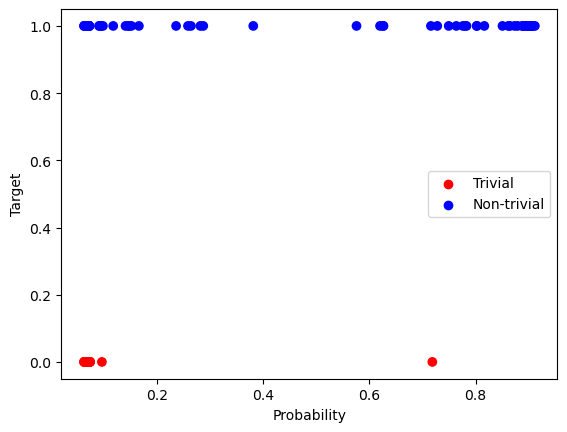

In [349]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract relevant columns for plotting
probabilities = adjusted_checkmate_predicted_vs_output['probability']
targets = adjusted_checkmate_predicted_vs_output['target']

# Define colors based on targets
colors = ['red' if target == 0 else 'blue' for target in targets]

# Plot the graph
plt.scatter(probabilities, targets, c=colors)
plt.xlabel('Probability')
plt.ylabel('Target')
plt.legend(handles=[plt.scatter([], [], c='red', label='Trivial'),
                    plt.scatter([], [], c='blue', label='Non-trivial')])

plt.show()


### Without finetuning

In [350]:
model = TFAutoModelForSequenceClassification.from_pretrained('mrm8488/bert-tiny-finetuned-sms-spam-detection', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [351]:
tokenized_spam_test = tokenizer(spam_dataset['test']['text'], return_tensors='np', padding=True, truncation=True)

outputs_spam_test = model(tokenized_spam_test).logits

prediction_spam_test = np.argmax(outputs_spam_test, axis=1)

In [352]:
print(type(tokenized_spam_test))
print((tokenized_spam_test).keys())
print(len(tokenized_spam_test['input_ids'][2]))
print(len(tokenized_spam_test['token_type_ids'][0]))
print(len(tokenized_spam_test['attention_mask'][0]))

print((tokenized_spam_test['input_ids'][2]))


<class 'transformers.tokenization_utils_base.BatchEncoding'>
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
238
238
238
[  101  4033  1005  1056  8828  2035  2154  1012  1045  1005  1049  3564
  2182  4582  2012  2023 28900 10733  1998  1045  2064  1005  1056  4521
  2009  1012  2122 19960  2015  2024 27853  2026  2166  1012   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0   

In [353]:
target_spam_test = np.array(spam_dataset['test']['is_not_trivial_proxy'])

In [354]:
print(target_spam_test)

[1 0 0 ... 1 0 0]


In [355]:
spam_predicted_vs_output = pd.DataFrame([spam_dataset['test']['text'],target_spam_test,prediction_spam_test]).T
spam_predicted_vs_output.rename(columns={0:'text', 1:'target',2:'prediction'}, inplace=True)

print(spam_predicted_vs_output)

                                                   text target prediction
0     Here is your discount code RP176781. To stop f...      1          1
1     Havent mus ask if u can 1st wat. Of meet 4 lun...      0          0
2     Haven't eaten all day. I'm sitting here starin...      0          0
3     Babe? You said 2 hours and it's been almost 4 ...      0          0
4                          Send me your id and password      0          0
...                                                 ...    ...        ...
4452   gonna let me know cos comes bak from holiday ...      0          0
4453  PRIVATE! Your 2003 Account Statement for <fone...      1          1
4454  LookAtMe!: Thanks for your purchase of a video...      1          1
4455  swhrt how u dey,hope ur ok, tot about u 2day.l...      0          0
4456  Please da call me any mistake from my side sor...      0          0

[4457 rows x 3 columns]


In [356]:
# Calculate the recall of this methodology
true_non_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==True)])
true_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==False)])

false_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==False)])
false_non_trivial = (spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==True)])


In [357]:
recall = len(true_non_trivial)/(len(true_non_trivial)+len(false_trivial))
precision = len(true_non_trivial)/(len(true_non_trivial)+len(false_non_trivial))
negativepredictivevalue = len(true_trivial)/(len(true_trivial)+len(false_trivial))
accuracy = (len(true_trivial)+len(true_non_trivial))/(len(true_trivial)+len(true_non_trivial)+len(false_trivial)+len(false_non_trivial))

print(f'Recall is: {recall*100}%')
print(f'Precision is: {precision*100}%')
print(f'Negative Predictive Value is: {negativepredictivevalue*100}%')
print(f'Accuracy is: {accuracy*100}%')

Recall is: 89.76897689768977%
Precision is: 97.4910394265233%
Negative Predictive Value is: 98.40984867914851%
Accuracy is: 98.29481714157505%


In [358]:
print(f'true_trivial is: {len(true_trivial)}')
print(f'true_non_trivial is: {len(true_non_trivial)}')
print(f'false_non_trivial is: {len(false_non_trivial)}')
print(f'false_trivial is: {len(false_trivial)}')

true_trivial is: 3837
true_non_trivial is: 544
false_non_trivial is: 14
false_trivial is: 62


In [360]:
tokenized_checkmate_test = tokenizer(checkmate_dataset['test']['text'], return_tensors='np', padding=True, truncation=True, max_length=248)

outputs_checkmate_test = model(tokenized_checkmate_test).logits

# Choose the larger of the logits between the two values
prediction_checkmate_test = np.argmax(outputs_checkmate_test, axis=1)

In [363]:
target_checkmate_test = np.array(checkmate_dataset['test']['is_not_trivial_proxy'])

In [364]:
checkmate_predicted_vs_output = pd.DataFrame([checkmate_dataset['test']['text'],target_checkmate_test,prediction_checkmate_test]).T
checkmate_predicted_vs_output.rename(columns={0:'text', 1:'target',2:'prediction'}, inplace=True)

print(checkmate_predicted_vs_output)

                                                 text target prediction
0                                               scam?      0          0
1   🙋‍♀ If you know anyone born between 1950-1959,...      1          0
2   Fast Cash Service                \n3k 268 x12m...      1          1
3                                               Hello      0          0
4                                                 nan      1          0
..                                                ...    ...        ...
79  🌧️ 🌧️ 🌧️ 🌧️ 🌧️ 🌧️ 🌧️ \n\n*From today until 30/...      1          0
80                                                nan      1          0
81                                                nan      1          0
82  Date: 24 March 2023 at 2:24:03 pm AEDT\nTo: \n...      1          0
83  Fast Cash Service                \n3k 268 x12m...      1          1

[84 rows x 3 columns]


In [365]:
# Calculate the recall of this methodology
true_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==True)])
true_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==False)])

false_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==False)])
false_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==True)])


In [366]:

# Non-trivial / Spam = 1
# Trivial / Ham = 0

recall = len(true_non_trivial)/(len(true_non_trivial)+len(false_trivial))
precision = len(true_non_trivial)/(len(true_non_trivial)+len(false_non_trivial))
negativepredictivevalue = len(true_trivial)/(len(true_trivial)+len(false_trivial))
accuracy = (len(true_trivial)+len(true_non_trivial))/(len(true_trivial)+len(true_non_trivial)+len(false_trivial)+len(false_non_trivial))

print(f'Recall is: {recall*100}%')
print(f'Precision is: {precision*100}%')
print(f'Negative Predictive Value is: {negativepredictivevalue*100}%')
print(f'Accuracy is: {accuracy*100}%')

Recall is: 56.25%
Precision is: 97.2972972972973%
Negative Predictive Value is: 40.42553191489361%
Accuracy is: 65.47619047619048%


In [367]:
print(f'true_trivial is: {len(true_trivial)}')
print(f'true_non_trivial is: {len(true_non_trivial)}')
print(f'false_non_trivial is: {len(false_non_trivial)}')
print(f'false_trivial is: {len(false_trivial)}')

true_trivial is: 19
true_non_trivial is: 36
false_non_trivial is: 1
false_trivial is: 28


Even without finetuning the data with spam, the results were not ideal.

In [383]:
print(true_non_trivial)

                                                 text target prediction
2   Fast Cash Service                \n3k 268 x12m...      1          1
6   AMEX: As your total unsecured interest-bearing...      1          1
7   LTA: Notice As no valid E-tag detected in your...      1          1
8   Dear Delegate, a gentle reminder that SMEICC 2...      1          1
10  Is this scam?\n\nInspired by mid-70s interiors...      1          1
11  https://www.8world.com/singapore/covid-19-spik...      1          1
12  🙁🤖😘您好！我是BARINGS俱乐部市场调查员Summer，同你核对一个事情，看到短信请添加...      1          1
15  Fast Cash Service                  \n3k 268 x1...      1          1
17       https://form.gov.sg/63f594b42413ea0011831e7e      1          1
20  So...... Starts walking!!!\n\nhttps://www.thev...      1          1
21  Hi good evening. How u get my Number ? My side...      1          1
23  https://traqr.gevme.com/scan/67745410/84a19d31...      1          1
25  World Cup Coming\nCome open your Acct\n*5Years...      1    

In [390]:
pd.set_option('display.max_colwidth', 300)
print(false_trivial)

                                                                                                                                                                                                                                                                                                           text  \
1   🙋‍♀ If you know anyone born between 1950-1959, you can ask them to go SMRT to top up $100 ezylink for Merdeka Generation effective today.\n\nHow to top up the $100? \n1. Go to a Add Value Machine at the mrt station.\n2. Place your Passion Senior Citizen card on the card reader.\n3. Tap on the wo...   
4                                                                                                                                                                                                                                                                                                           nan   
5   This is one of the most profound description of the Chinese race by Chan- L

#### Saving Model

In [ ]:
model.save_pretrained('../../models/classifier/BERT_TINY_finetuned_sms_spam_detection')

In [ ]:
tokenizer.save_pretrained('../../models/tokeniser/BERT_TINY_finetuned_sms_spam_detection')

('../../models/tokeniser/BERT_TINY_finetuned_sms_spam_detection/tokenizer_config.json',
 '../../models/tokeniser/BERT_TINY_finetuned_sms_spam_detection/special_tokens_map.json',
 '../../models/tokeniser/BERT_TINY_finetuned_sms_spam_detection/vocab.txt',
 '../../models/tokeniser/BERT_TINY_finetuned_sms_spam_detection/added_tokens.json',
 '../../models/tokeniser/BERT_TINY_finetuned_sms_spam_detection/tokenizer.json')

## Load Checkmate Pretrained model
Load the model for classification

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import pandas as pd
import numpy as np

In [ ]:
checkmate_tokenizer = AutoTokenizer.from_pretrained('../../models/tokeniser/BERT_TINY_finetuned_sms_spam_detection')

In [ ]:
checkmate_model = TFAutoModelForSequenceClassification.from_pretrained('../../models/classifier/BERT_TINY_finetuned_sms_spam_detection')

Some layers from the model checkpoint at ../../models/classifier/BERT_TINY_finetuned_sms_spam_detection were not used when initializing TFBertForSequenceClassification: ['dropout_15']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../../models/classifier/BERT_TINY_finetuned_sms_spam_detection.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without fur

In [ ]:
test_tokens = checkmate_tokenizer('Hello,My company needs some part-time workers now, are you interested in joining? [21:06, 10/05/2023] +1 (447) 842-2867: Daily salary S$ 450-600  Do you have time to understand now?', return_tensors='np', padding=True, truncation=True)

test_output = checkmate_model(test_tokens).logits
print(test_output)

prediction_spam_test = np.argmax(test_output, axis=1)
print(prediction_spam_test)

tf.Tensor([[-1.0315554  1.0928826]], shape=(1, 2), dtype=float32)
[1]


### Conclusion

The TINY BERT model finetuned using the spam dataset did not perform very well on the dataset available as shown above. Even despite finetuning and changing the threshold for classfication, we were unable to achieve a desirable result. Hence, an alternative model would be preferred. Observing the wrongly classified non-trivial (as trivial) cases, we notice that the statements are conversational/more in the news realm. This means that the model is specifically bad at classifying fake news/fact related messages even though promotional items are easily identified.